In [1]:
from music21 import *
import matplotlib.pyplot as plt
import math
import numpy as np
import music21.common as common
from fractions import Fraction

In [2]:
n1 = note.Note()

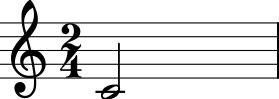

In [3]:
n1.quarterLength = 2
n1.show()

In [4]:
ch = converter.parse('Cherbourg.xml')

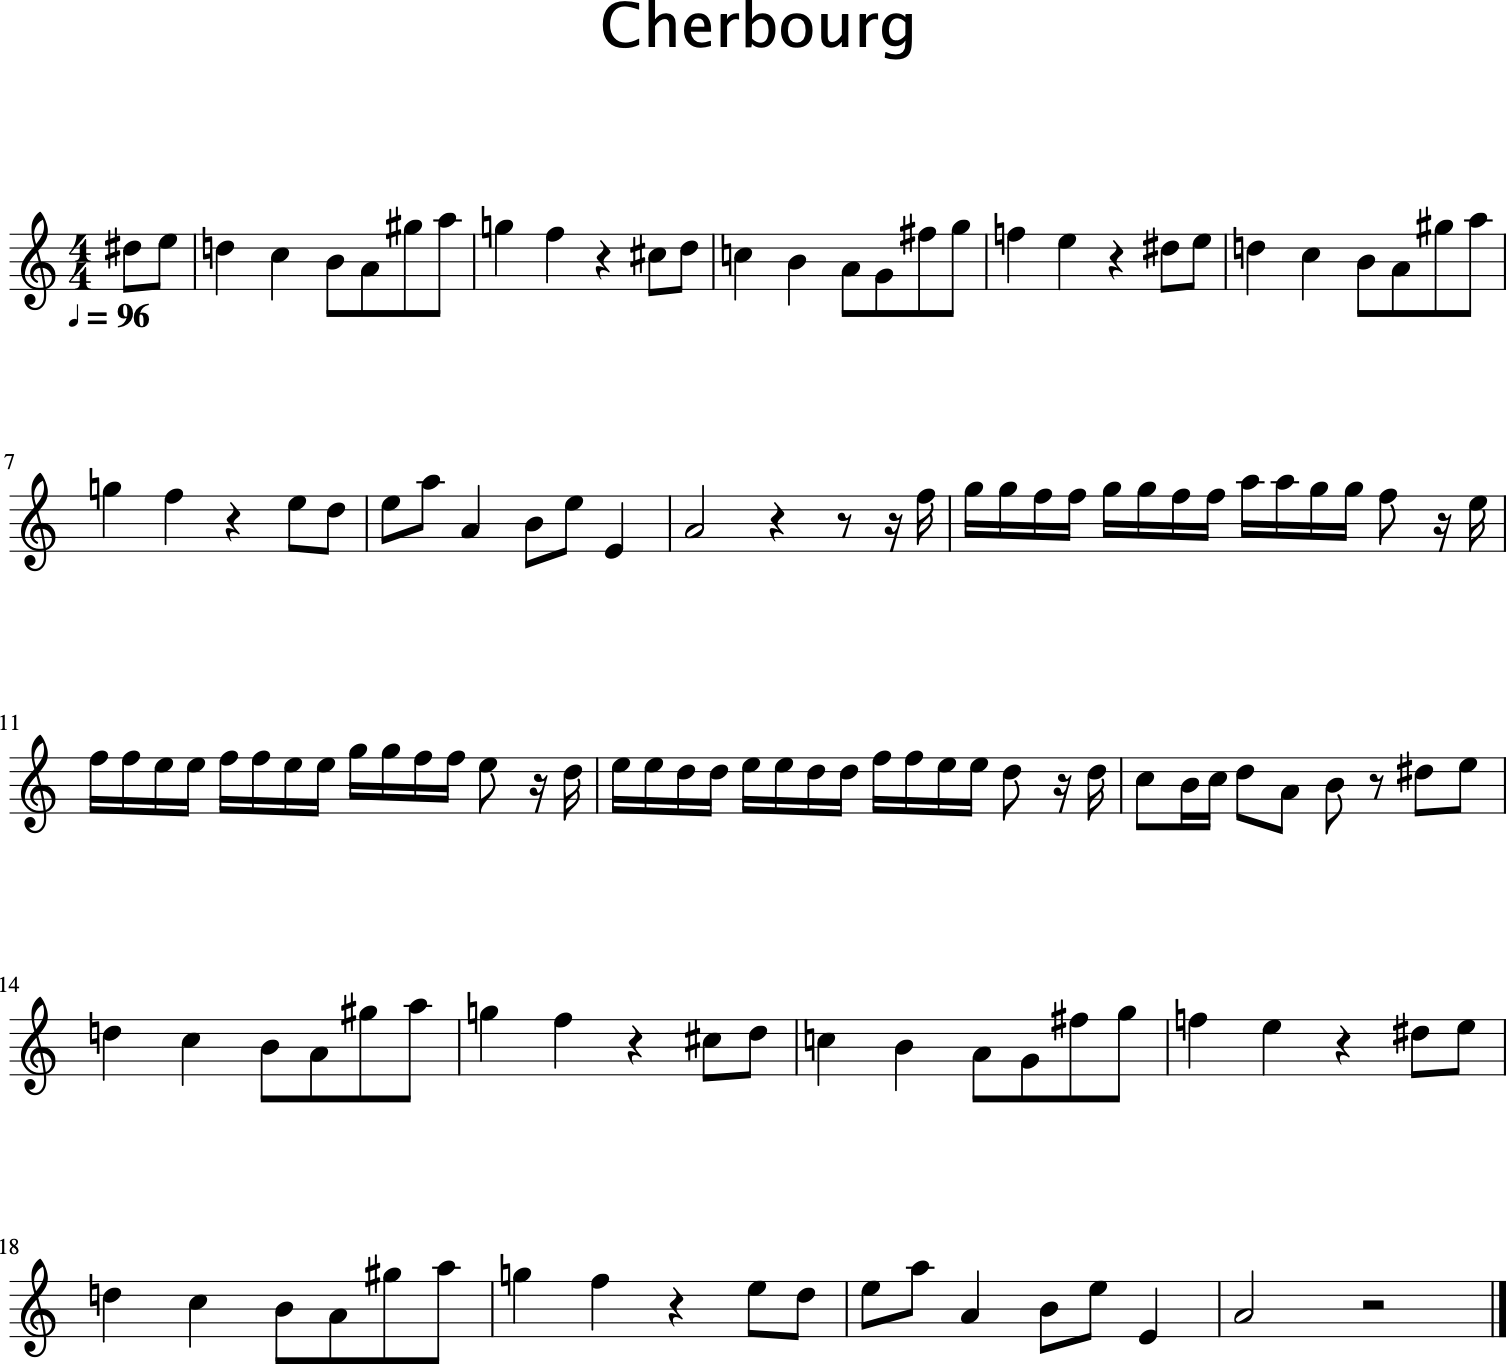

In [5]:
ch.show()

In [6]:
for i in ch[2][2]:
    print(i.duration)

<music21.duration.Duration 1.0>
<music21.duration.Duration 1.0>
<music21.duration.Duration 0.5>
<music21.duration.Duration 0.5>
<music21.duration.Duration 0.5>
<music21.duration.Duration 0.5>


In [5]:
def splitbystc_norest(sheet):
    stclist = []
    stc = []
    kk = 0
    for m in sheet[1:]:
        for n in m:
            try:
                if n.isRest:
                    if len(stc)>0:
                        stclist.append(stc)
                        stc = []
                        kk = 0
                if n.isNote:
                    stc.append([str(n.pitch), n.pitch.midi, n.quarterLength])
                    kk = 1
            except:
                print(n)
    print(len(stc))
    if kk == 1 and len(stc) != 0:
        stclist.append(stc)
    return stclist   

In [56]:
s = splitbystc_norest(ch[2])

<music21.layout.PageLayout>
<music21.layout.SystemLayout>
<music21.layout.StaffLayout distance None, staffNumber 1, staffSize None, staffLines None>
<music21.clef.TrebleClef>
<music21.tempo.MetronomeMark Quarter=96.0>
a minor
<music21.meter.TimeSignature 4/4>
<music21.layout.SystemLayout>
<music21.layout.StaffLayout distance None, staffNumber 1, staffSize None, staffLines None>
<music21.layout.SystemLayout>
<music21.layout.StaffLayout distance None, staffNumber 1, staffSize None, staffLines None>
<music21.layout.SystemLayout>
<music21.layout.StaffLayout distance None, staffNumber 1, staffSize None, staffLines None>
<music21.layout.SystemLayout>
<music21.layout.StaffLayout distance None, staffNumber 1, staffSize None, staffLines None>
<music21.bar.Barline type=final>


In [6]:
def compute_MCG(stc):
    d = 0
    s = 0
    for n in stc:
        s += n[1]*n[2]
        d += n[2]
    return s/d

def compute_MCG_series(stclist, is_show=True):
    l = []
    for stc in stclist:
        l.append(compute_MCG(stc))
    if is_show:
        plt.plot(range(1,len(l)+1),l)
    return l

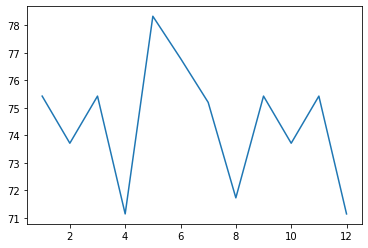

In [58]:
mcgs = compute_MCG_series(s)
foo_fig = plt.gcf() # 'get current figure'
foo_fig.savefig('mcgs.eps', format='eps', dpi=1000)
plt.show()

In [7]:
def LMD(n1, n2):
    """n:[note, pitch, duration]"""
    p1 = max(0,n1[1]-n2[1])
    p2 = max(0,n2[1]-n1[1])
    d1 = n1[2]/(n1[2]+n2[2])*math.exp(1/n1[2]+n2[2])
    d2 = n2[2]/(n1[2]+n2[2])*math.exp(1/n1[2]+n2[2])
    lmd = math.fabs(p1*d1 - p2*d2)
    return lmd

def GMD_series(stc):
    num = len(stc)
    if num < 2:
        return None
    gmds = []
    for i in range(num-1):
        gmds.append(LMD(stc[i], stc[i+1]))
    return gmds

def GMD(stc, norm='inf', reduction='sum'):
    gmds = GMD_series(stc)
    if norm == 'inf':
        if reduction == 'sum':
            return max(gmds)
        elif reduction == 'mean':
            return max(gmds)/len(gmds)
    elif norm == 1:
        if reduction == 'sum':
            return sum(gmds)
        elif reduction == 'mean':
            return sum(gmds)/len(gmds)
    else:
        print('Invalid norm/reduction!')
        return None

def stcwise_GMD_series(stclist, norm='inf', reduction='sum', is_show=True):
    l = []
    for stc in stclist:
        l.append(GMD(stc, norm, reduction))
    if is_show:
        plt.plot(range(1,len(l)+1),l)
    return l

In [30]:
stcwise_GMD_series(s,'inf','sum')
foo_fig = plt.gcf() # 'get current figure'
foo_fig.savefig('gmds.eps', format='eps', dpi=1000)
plt.show()

NameError: name 's' is not defined

In [8]:
def get_stc_rhythm(stc):
    l = []
    for n in stc:
        l.append(n[2])
    return l

def get_stclist_rhythm(stclist):
    l = []
    for stc in stclist:
        l.append(get_stc_rhythm(stc))
    return l

In [9]:
def delta_timeseries(ts):
    num = len(ts)
    if num < 2:
        print('Error!')
        return None
    l = []
    for i in range(num-1):
        if (ts[i]+ts[i+1]) > 0:
            s = math.fabs((ts[i+1]-ts[i])*2/(ts[i]+ts[i+1]))
        else:
            s = 0
        l.append(s)
    return l

def PV_series(stc, is_show=False):
    rhy = get_stc_rhythm(stc)
    pvs = delta_timeseries(rhy)
    if is_show:
        plt.plot(pvs)
    return pvs

def PV(stc, norm=1, reduction='mean'):
    pvs = PV_series(stc)
    if norm == 'inf':
        if reduction == 'sum':
            return max(pvs)
        elif reduction == 'mean':
            return max(pvs)/len(pvs)
    elif norm == 1:
        if reduction == 'sum':
            return sum(pvs)
        elif reduction == 'mean':
            return sum(pvs)/len(pvs)
    else:
        print('Invalid norm/reduction!')
        return None
    
def stcwise_PV_series(stclist, norm=1, reduction='mean', is_show=True):
    l = []
    for stc in stclist:
        l.append(PV(stc, norm, reduction))
    if is_show:
        plt.plot(range(1,len(l)+1),l)
    return l

def RD_series(stc, is_show=False):
    rhy = get_stc_rhythm(stc)
    rds = delta_timeseries(delta_timeseries(rhy))
    if is_show:
        plt.plot(rds)
    return rds

def RD(stc, norm=1, reduction='mean'):
    rds = RD_series(stc)
    if norm == 'inf':
        if reduction == 'sum':
            return max(rds)
        elif reduction == 'mean':
            return max(rds)/len(rds)
    elif norm == 1:
        if reduction == 'sum':
            return sum(rds)
        elif reduction == 'mean':
            return sum(rds)/len(rds)
    else:
        print('Invalid norm/reduction!')
        return None

def stcwise_RD_series(stclist, norm=1, reduction='mean', is_show=True):
    l = []
    for stc in stclist:
        l.append(RD(stc, norm, reduction))
    if is_show:
        plt.plot(range(1,len(l)+1),l)
    return l

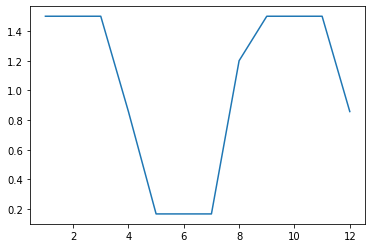

In [32]:
stcwise_RD_series(s)
foo_fig = plt.gcf() # 'get current figure'
foo_fig.savefig('rds.eps', format='eps', dpi=1000)
plt.show()

In [13]:
xm = converter.parse('旋木.musicxml')

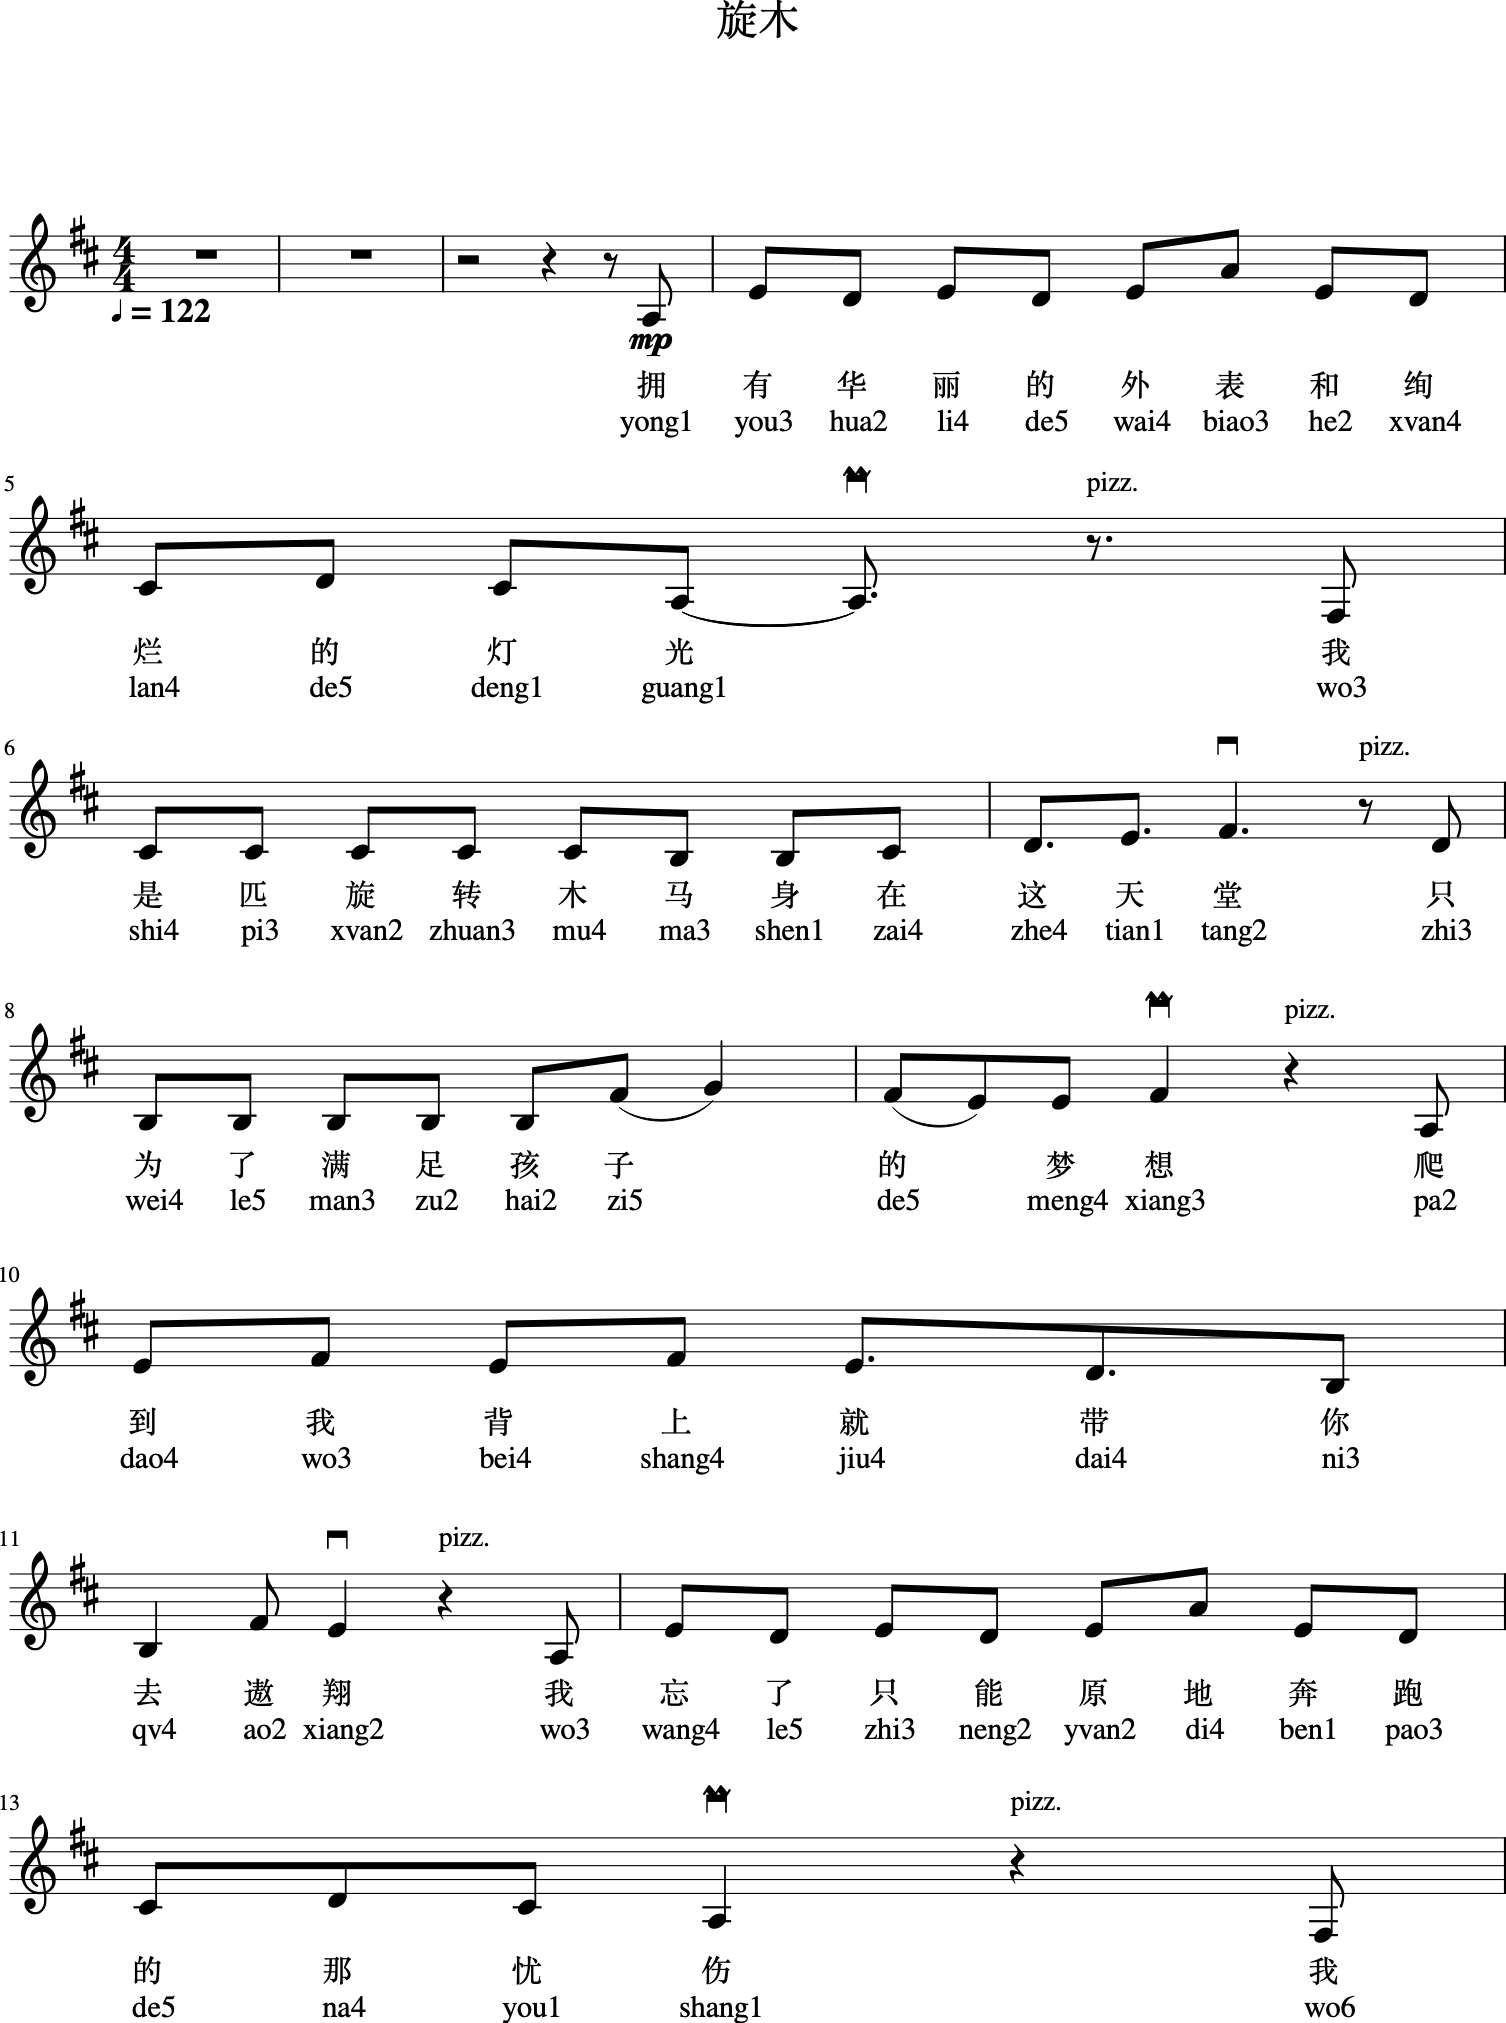

In [14]:
xm.show()

In [26]:
x = splitbystc_norest(xm[2])
x = x[:18]

<music21.layout.SystemLayout>
<music21.clef.TrebleClef>
<music21.tempo.MetronomeMark animato Quarter=122.0>
<music21.key.KeySignature of 2 sharps>
<music21.meter.TimeSignature 4/4>
<music21.dynamics.Dynamic mp >
<music21.expressions.TextExpression "pizz.">
<music21.layout.SystemLayout>
<music21.expressions.TextExpression "pizz.">
<music21.layout.SystemLayout>
<music21.expressions.TextExpression "pizz.">
<music21.layout.SystemLayout>
<music21.expressions.TextExpression "pizz.">
<music21.expressions.TextExpression "pizz.">
<music21.layout.SystemLayout>
<music21.expressions.TextExpression "pizz.">
<music21.layout.SystemLayout>
<music21.expressions.TextExpression "pizz.">
<music21.layout.SystemLayout>
<music21.layout.PageLayout>
<music21.layout.SystemLayout>
<music21.expressions.TextExpression "pizz.">
<music21.dynamics.Dynamic mf >
<music21.expressions.TextExpression "pizz.">
<music21.layout.SystemLayout>
<music21.expressions.TextExpression "pizz.">
<music21.expressions.TextExpression "pi

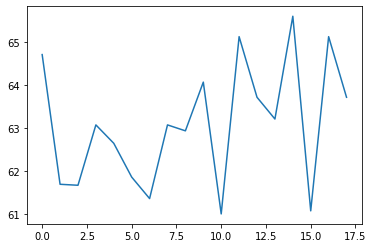

In [27]:
xmcgs = compute_MCG_series(x)

[0.694112993531563,
 3.279902220189397,
 3.8762480784056508,
 3.8762480784056508,
 4.263872886246216,
 3.5532274052051798,
 3.8762480784056508,
 3.8762480784056508,
 2.7596209965576928,
 3.0456234901758683,
 5.842117695557321,
 4.017107384637534,
 3.0456234901758683,
 6.091246980351737,
 3.0456234901758683,
 2.7687486274326076,
 4.017107384637534,
 3.0456234901758683]

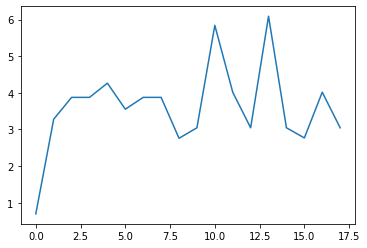

In [30]:
stcwise_GMD_series(x,'inf','mean')

[0.44799999999999995,
 0.16666666666666666,
 0.6,
 0.6,
 0.7222222222222222,
 0.18181818181818182,
 0.6,
 0.6,
 0.18181818181818182,
 0.6666666666666666,
 0.5974025974025974,
 1.0,
 1.3333333333333333,
 1.0833333333333333,
 0.6666666666666666,
 0.2,
 1.0,
 1.3333333333333333]

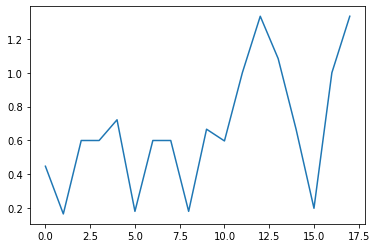

In [39]:
stcwise_RD_series(x)

In [33]:
rd_sw = converter.parse('rd_swing_example.mxl')

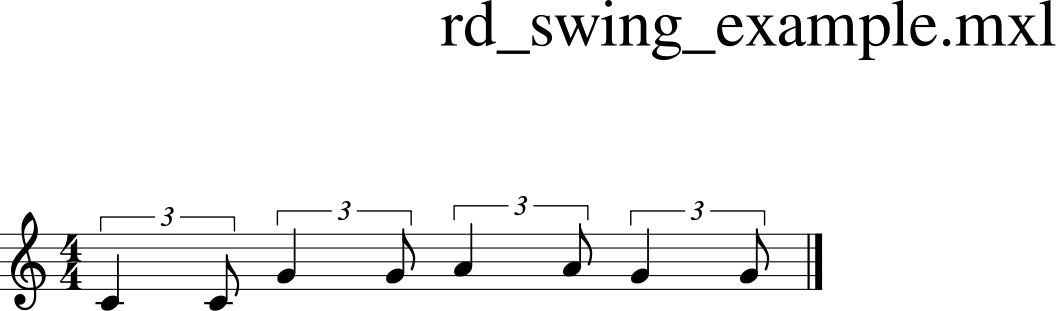

In [34]:
rd_sw.show()

In [109]:
sw = splitbystc_norest(rd_sw[1])
PV(sw[0])

<music21.layout.PageLayout>
<music21.layout.SystemLayout>
<music21.layout.StaffLayout distance None, staffNumber 1, staffSize None, staffLines None>
<music21.clef.TrebleClef>
C major
<music21.meter.TimeSignature 4/4>
<music21.bar.Barline type=final>
8


0.6666666666666666

In [110]:
GMD(sw[0])

182.56599199138162

In [111]:
rd_nm = converter.parse('rd_normal_example.mxl')
nm = splitbystc_norest(rd_nm[1])

<music21.layout.PageLayout>
<music21.layout.SystemLayout>
<music21.layout.StaffLayout distance None, staffNumber 1, staffSize None, staffLines None>
<music21.clef.TrebleClef>
C major
<music21.meter.TimeSignature 4/4>
<music21.bar.Barline type=final>
8


In [112]:
GMD(nm[0])

42.63872886246216

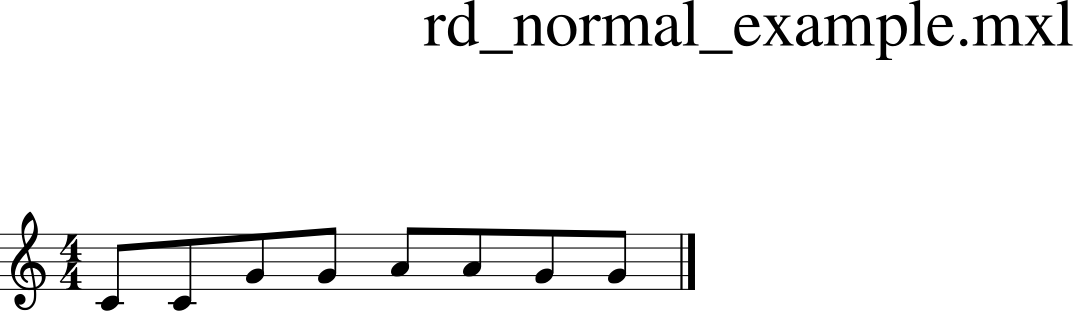

In [107]:
rd_nm.show()

In [3]:
flm = converter.parse('fly me to the moon.xml')

In [12]:
flmm = splitbystc_norest(flm[3])

<music21.expressions.RehearsalMark 'A'>
<music21.layout.PageLayout>
<music21.layout.SystemLayout>
<music21.layout.StaffLayout distance None, staffNumber 1, staffSize None, staffLines None>
<music21.clef.TrebleClef>
C major
<music21.meter.TimeSignature 4/4>
<music21.layout.SystemLayout>
<music21.layout.StaffLayout distance None, staffNumber 1, staffSize None, staffLines None>
<music21.expressions.RehearsalMark 'B'>
<music21.layout.SystemLayout>
<music21.layout.StaffLayout distance None, staffNumber 1, staffSize None, staffLines None>
<music21.layout.SystemLayout>
<music21.layout.StaffLayout distance None, staffNumber 1, staffSize None, staffLines None>
<music21.bar.Barline type=final>
3


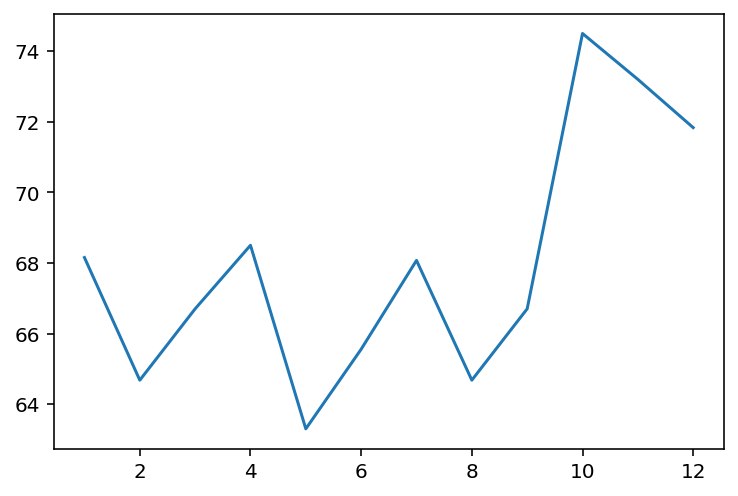

In [14]:
flm_mcgs = compute_MCG_series(flmm)
foo_fig = plt.gcf() # 'get current figure'
foo_fig.savefig('flm_mcgs.eps', format='eps', dpi=1000)
plt.show()

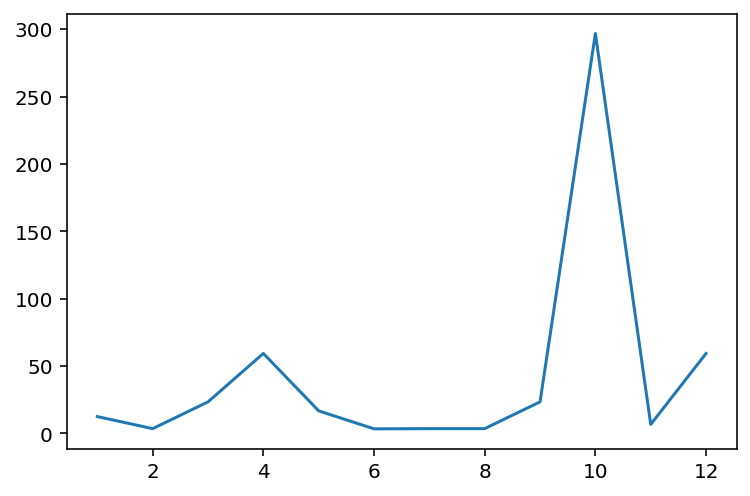

In [45]:
stcwise_GMD_series(flmm, 'inf', 'mean')
foo_fig = plt.gcf() # 'get current figure'
foo_fig.savefig('flm_gmds.eps', format='eps', dpi=1000)
plt.show()

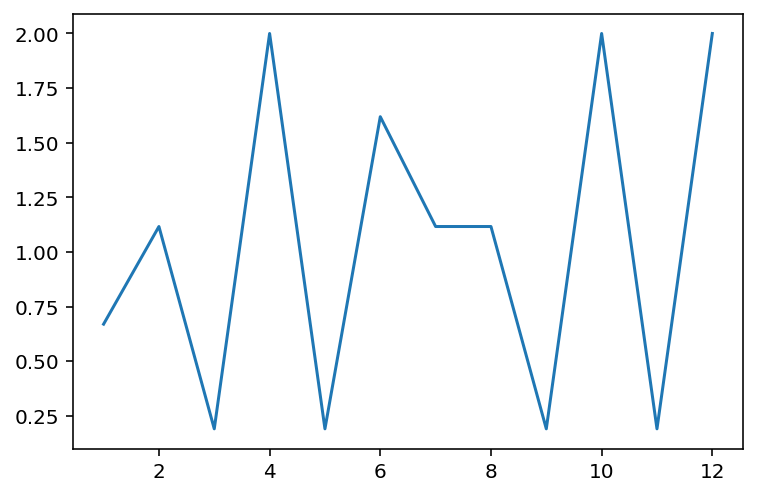

In [20]:
stcwise_RD_series(flmm)
foo_fig = plt.gcf() # 'get current figure'
foo_fig.savefig('flm_rds.eps', format='eps', dpi=1000)
plt.show()

In [21]:
al = converter.parse('autumn leaves.xml')

In [27]:
alm = splitbystc_norest(al[3])

<music21.expressions.RehearsalMark 'A'>
<music21.layout.PageLayout>
<music21.layout.SystemLayout>
<music21.layout.StaffLayout distance None, staffNumber 1, staffSize None, staffLines None>
<music21.clef.TrebleClef>
E- major
<music21.meter.TimeSignature 4/4>
<music21.layout.SystemLayout>
<music21.layout.StaffLayout distance None, staffNumber 1, staffSize None, staffLines None>
<music21.expressions.RehearsalMark 'B'>
<music21.layout.SystemLayout>
<music21.layout.StaffLayout distance None, staffNumber 1, staffSize None, staffLines None>
<music21.layout.SystemLayout>
<music21.layout.StaffLayout distance None, staffNumber 1, staffSize None, staffLines None>
<music21.bar.Barline type=final>
0


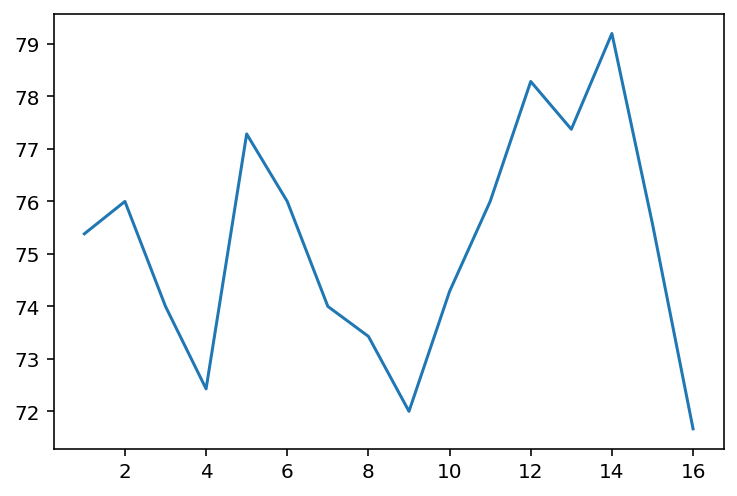

In [28]:
al_mcgs = compute_MCG_series(alm)
foo_fig = plt.gcf() # 'get current figure'
foo_fig.savefig('al_mcgs.eps', format='eps', dpi=1000)
plt.show()

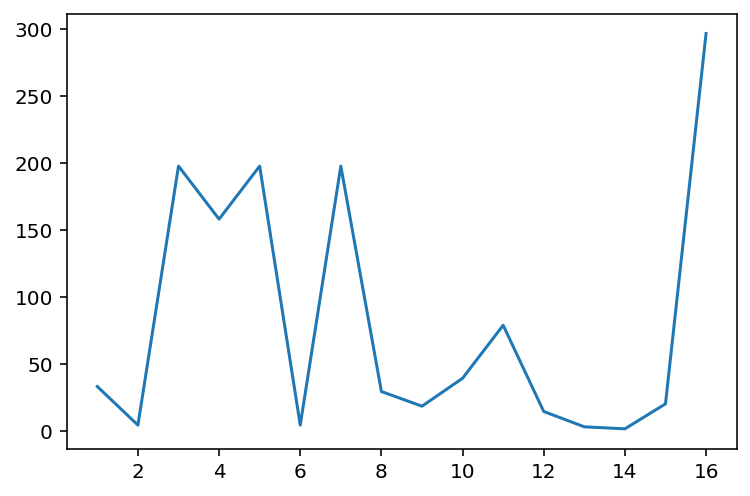

In [51]:
stcwise_GMD_series(alm, 'inf', 'mean')
foo_fig = plt.gcf() # 'get current figure'
foo_fig.savefig('al_gmds.eps', format='eps', dpi=1000)
plt.show()

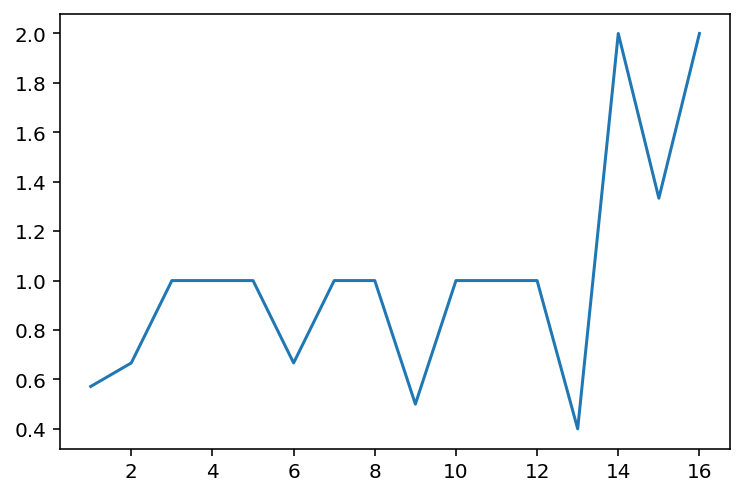

In [52]:
stcwise_RD_series(alm)
foo_fig = plt.gcf() # 'get current figure'
foo_fig.savefig('al_rds.eps', format='eps', dpi=1000)
plt.show()

In [54]:
ly = converter.parse('Love Yourself.xml')

In [56]:
lym = splitbystc_norest(ly[4])

<music21.layout.PageLayout>
<music21.layout.SystemLayout>
<music21.layout.StaffLayout distance None, staffNumber 1, staffSize None, staffLines None>
<music21.clef.TrebleClef>
D major
<music21.meter.TimeSignature 4/4>
<music21.bar.Repeat direction=start>
<music21.layout.SystemLayout>
<music21.layout.StaffLayout distance None, staffNumber 1, staffSize None, staffLines None>
<music21.layout.SystemLayout>
<music21.layout.StaffLayout distance None, staffNumber 1, staffSize None, staffLines None>
<music21.layout.SystemLayout>
<music21.layout.StaffLayout distance None, staffNumber 1, staffSize None, staffLines None>
<music21.layout.SystemLayout>
<music21.layout.StaffLayout distance None, staffNumber 1, staffSize None, staffLines None>
<music21.layout.SystemLayout>
<music21.layout.StaffLayout distance None, staffNumber 1, staffSize None, staffLines None>
<music21.layout.SystemLayout>
<music21.layout.StaffLayout distance None, staffNumber 1, staffSize None, staffLines None>
<music21.layout.Syst

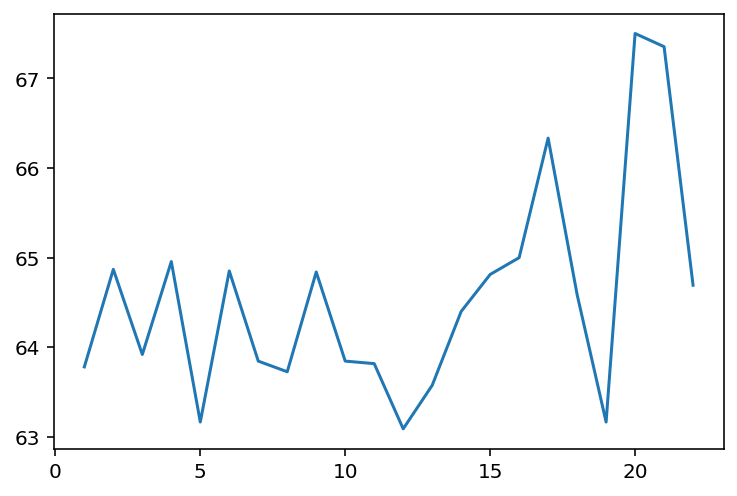

In [58]:
ly_mcgs = compute_MCG_series(lym)
foo_fig = plt.gcf() # 'get current figure'
foo_fig.savefig('ly_mcgs.eps', format='eps', dpi=1000)
plt.show()

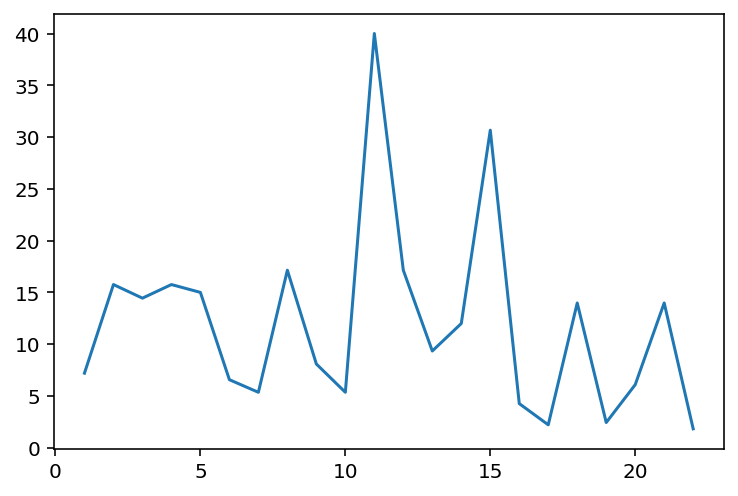

In [61]:
stcwise_GMD_series(lym, 'inf', 'mean')
foo_fig = plt.gcf() # 'get current figure'
foo_fig.savefig('ly_gmds.eps', format='eps', dpi=1000)
plt.show()

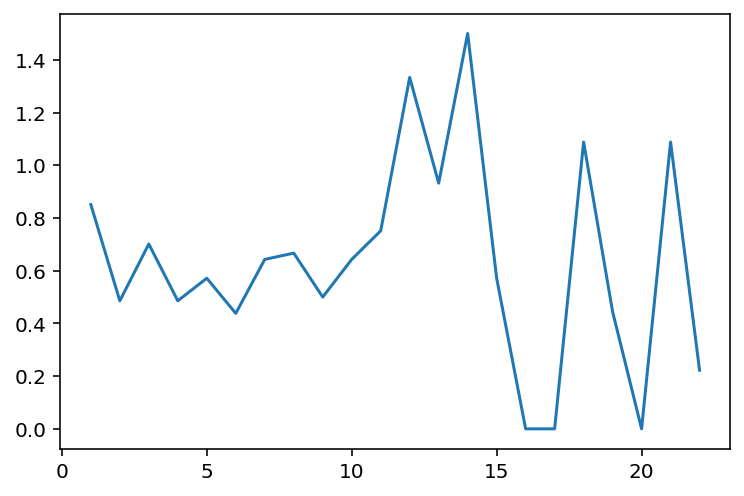

In [62]:
stcwise_RD_series(lym)
foo_fig = plt.gcf() # 'get current figure'
foo_fig.savefig('ly_rds.eps', format='eps', dpi=1000)
plt.show()